# Active Learning Practical

Active Learning is generally useful in a specific case of small data: when unlabelled data is plentiful, but labelling it is costly. Think for example that each example must be analysed by an expert for labelling it. Expert time is costly, so we would like to be able to train a successful classifier while labelling as few examples as possible.

Active Learning is an approach to answer this problem. The general principle is the following: we first randomly ask the expert to label a small random subset of the training data, and train our classifier on it. Once this first step is done, we can analyse the behaviour of our trained model on the yet unlabelled data, to deduce which additional examples would be worth labelling to improve the quality of the model as quickly as possible. We then retrain the model on the new larger labelled dataset and iterate this process, labelling more and more examples, until we reach a satisfying performance. And hopefully reaching it while only labelling a small fraction of the whole available dataset.

The main question in Active Learning is thus the following: How should we choose the next batch of examples to be labelled?

There are different strategies for this, that you will compare in this practical.

### Example setup

We will emulate an active learning situation using the MNIST dataset, starting by pretending we don't have the labels. The "ask an expert to label the example" step will thus be simply picking the label from the dataset.

You'll have to provide a neural network architecture and the implementation of various active learning strategies, with the goal of comparing them. Keep in mind that the start of the training will be on very small datasets when designing your architectures.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset

import matplotlib.pyplot as plt
%matplotlib inline

import time

# reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
# Loading MNIST dataset from torchvision.dataset
original_mnist = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

In [0]:
# This function creates an unlabelled dataset based on the MNIST images
#
# All examples that are not yet labelled have a label set to -1
def unlabeled_dataset():
    return TensorDataset(
        original_mnist.data[5000:].float() * 2.0 / 255.0 -1.0,
        torch.zeros_like(original_mnist.targets[5000:])-1
    )

# This function labels the requested examples on an unlabelled dataset
def call_expert(dataset, indices):
    for i in indices:
        dataset.tensors[1][i] = original_mnist.targets[5000+i]

# Keep 5000 examples as a validation
mnist_validation = TensorDataset(
    original_mnist.data[:5000].float() * 2.0 / 255.0 -1.0,
    original_mnist.targets[:5000]
)

You can here define your model that will be used for the Active learning process:

In [0]:
class Model(nn.Module):
    r"""
        The architecture of the model is strongly inspired from `CAPTCHA Recognition with Active Deep Learning` (Stark et. al., 2015)
    """
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 48, 3, padding=2, stride=2)
        self.conv2 = nn.Conv2d(48, 64, 3, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=2)

        # Pooling layers
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2, stride=2)

        # Linear layers
        self.fc1 = nn.Linear(128*3*3, 128)
        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()

    def forward(self, x):
        B, H, W = x.shape
        x = x.view(B, 1, H, W)
        h = self.conv1(x)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dropout(h)

        h = self.conv2(h)
        h = self.pool2(h)
        h = self.relu(h)
        h = self.dropout(h)

        h = self.conv3(h)
        h = self.pool3(h)
        h = self.relu(h)
        h = self.dropout(h)

        h = h.view(B, -1)
        h = self.fc1(h)
        h = self.relu(h)
        h = self.dropout(h)
        output = self.fc2(h) 
        return output

And here are the learning hyper-parameters, as for the previous practicals you may need to tinker with them:

In [0]:
hyperparams = {
    # number of times the expert will be called to label a batch of examples
    'num_active_runs': 10,

    # number of training iterations between each expert call
    # the number of epochs is thus num_iter * batch_size / len(dataset)
    'num_iter': 1000,
    'batch_size': 128,

    'criterion': nn.CrossEntropyLoss(),

    # Optimizer params
    'learning_rate': 1e-3,
    'lr_decay': 1,

    # number of examples to label randomly at the start, and how many to add at each step
    'initial_labelling': 50,
    'labelling_per_run': 50
}

Now is the place where you define the strategy to choose the next examples to label. A strategy is a function taking as input your model and the dataset, and returning a list of examples to label.

You can create several functions to test different strategies.

In [0]:
def random_strategy(model, dataset, n=100):
    # label 100 new examples at random
    N = len(dataset)
    return torch.randint(0, N, (n,))

def bvsb_strategy(model, dataset, n=100): # best strategy
    r"""
        Best-versus-Second-Best strategy described in `Multi-class active learning for image classification` (Joshi et. al., 2009)
        Uncertainty is defined as score(second best) / score(best), then the most
        uncertain examples are added to the dataset
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
    with torch.no_grad():
        # compute the scores of each element in the dataset
        data, _ = next(iter(loader))
        if torch.cuda.is_available():
            data = data.cuda()
        scores = model(data)
        
        # compute uncertainty as score_second_best / score_best
        best_scores = torch.topk(scores, 2, dim=1).values
        uncertainty = best_scores[:,1] / best_scores[:,0]

    return torch.topk(uncertainty, n).indices

def uncertainty_strategy(model, dataset, n=100):
    r"""
        Pick the samples with lowest prediction confidence
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
    with torch.no_grad():
        # compute the scores of each element in the dataset
        data, _ = next(iter(loader))
        if torch.cuda.is_available():
            data = data.cuda()
        scores = model(data)
        
        confidence = torch.max(scores, dim=1).values

    return torch.topk(-confidence, n).indices

def margin_strategy(model, dataset, n=100):
    r"""
        Pick the samples by the difference between the highest classes probabilities.
        Very similar to BvSB strategy.
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
    with torch.no_grad():
        # compute the scores of each element in the dataset
        data, _ = next(iter(loader))
        if torch.cuda.is_available():
            data = data.cuda()
        scores = model(data)
        
        # compute uncertainty as score_second_best / score_best
        best_scores = torch.topk(scores, 2, dim=1).values
        confidence = best_scores[:,0] - best_scores[:,1]

    return torch.topk(confidence, n).indices

def margin_strategy(model, dataset, n=100):
    r"""
        Pick the samples by the difference between the highest classes probabilities.
        Very similar to BvSB strategy.
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
    with torch.no_grad():
        # compute the scores of each element in the dataset
        data, _ = next(iter(loader))
        if torch.cuda.is_available():
            data = data.cuda()
        scores = model(data)
        
        # compute uncertainty as score_second_best / score_best
        best_scores = torch.topk(scores, 2, dim=1).values
        confidence = best_scores[:,0] - best_scores[:,1]

    return torch.topk(-confidence, n).indices

def _entropy(p, dim=-1):
    # Implementation found in https://github.com/pytorch/pytorch/issues/9993
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim)

def entropy_strategy(model, dataset, n=100):
    r"""
        Pick samples with maximal entropy
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
    with torch.no_grad():
        # compute the scores of each element in the dataset
        data, _ = next(iter(loader))
        if torch.cuda.is_available():
            data = data.cuda()
        scores = model(data)
        
        # compute entropy
        entropy = _entropy(scores)

    return torch.topk(entropy, n).indices

This function is the main training loop, the only part you should need to modify is the initialization of the optimizer (noted by the `# OPTIMIZER` comment).

Don't forget to reload this cell whenever you change the hyper-parameters.

In [0]:
# returns a tensor of values:
# - output[:,0] are the number of labeled examples
# - output[:,1] are the associated accuracies
# - output[:,2] are the associated losses
def active_training(strategy, dataset=None, num_active_runs=10, num_iter=500,
                    batch_size=64, criterion=nn.CrossEntropyLoss(), learning_rate=1e-3,
                    lr_decay=1, initial_labelling=100, labelling_per_run=50):
    is_cuda = torch.cuda.is_available()
    if dataset is None:
        dataset = unlabeled_dataset()
        call_expert(dataset, torch.randint(0, len(dataset), (initial_labelling,)))
    
    def train_model(model, optimizer, loader, epochs):
        model.train()
        for _ in range(epochs):
            for (data, targets) in loader:
                if is_cuda:
                    data = data.cuda()
                    targets = targets.cuda()
                model.zero_grad()
                prediction = model(data)
                loss = criterion(prediction, targets)
                loss.backward()
                optimizer.step()
    
    def validation_perf(model, dataset):
        model.eval()
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        total_accuracy = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for (data, targets) in loader:
                if is_cuda:
                    data = data.cuda()
                    targets = targets.cuda()
                prediction = model(data)
                total_loss += criterion(prediction, targets).item() * data.size(0)
                _, number_predicted = torch.max(prediction.data, 1)
                total_accuracy += (number_predicted == targets).sum()
        return (total_accuracy / len(dataset), total_loss / len(dataset))
    
    performances = torch.zeros(num_active_runs+1, 3)
    
    for i in range(num_active_runs+1):
        # filter the dataset to only keep labelled examples
        labelled_idx = dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
        # create a new model to train on this dataset
        model = Model()
        if is_cuda:
          model = model.cuda()
        
        # OPTIMIZER
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        learning_rate *= lr_decay

        train_model(model, optimizer, loader, num_iter // len(loader))
        (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
        
        performances[i, 0] = len(filtered_dataset)
        performances[i, 1] = valid_acc
        performances[i, 2] = valid_loss
        print("With {} examples, valid perf is: {:.3f} -- {:.2f}%".format(len(filtered_dataset), valid_loss, valid_acc*100))
        
        if i < num_active_runs:
            to_label = strategy(model, dataset, labelling_per_run)
            call_expert(dataset, to_label)
    
    return performances

The following cells contain code that you can use to compare your different strategies. Fill the `strategies` list with the name of the functions implementing your strategies, and run the cell to compare them.

In [8]:
# a list of strategies you want to compare
strategies = [
    random_strategy,
    bvsb_strategy,
    uncertainty_strategy,
    margin_strategy,
    entropy_strategy
]

performances = []
for strat in strategies:
    # reproducibility
    torch.manual_seed(0)

    print("Training with strategy: {}".format(strat.__name__))
    perf = active_training(strat, **hyperparams)
    performances.append((strat.__name__, perf))
print("done")

Training with strategy: random_strategy
With 50 examples, valid perf is: 1.679 -- 76.38%
With 100 examples, valid perf is: 0.661 -- 87.38%
With 150 examples, valid perf is: 0.361 -- 90.96%
With 200 examples, valid perf is: 0.268 -- 93.42%
With 249 examples, valid perf is: 0.260 -- 93.64%
With 299 examples, valid perf is: 0.256 -- 93.60%
With 349 examples, valid perf is: 0.236 -- 94.38%
With 398 examples, valid perf is: 0.221 -- 93.84%
With 448 examples, valid perf is: 0.216 -- 94.78%
With 498 examples, valid perf is: 0.198 -- 94.88%
With 547 examples, valid perf is: 0.210 -- 94.26%
Training with strategy: bvsb_strategy
With 50 examples, valid perf is: 1.679 -- 76.38%
With 100 examples, valid perf is: 0.822 -- 86.52%
With 150 examples, valid perf is: 0.352 -- 90.96%
With 200 examples, valid perf is: 0.222 -- 94.38%
With 250 examples, valid perf is: 0.184 -- 95.38%
With 300 examples, valid perf is: 0.163 -- 95.70%
With 350 examples, valid perf is: 0.143 -- 96.02%
With 400 examples, valid

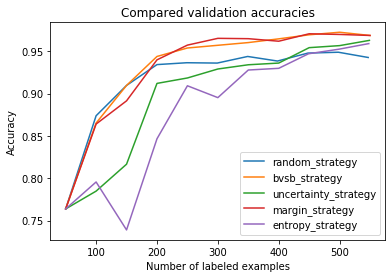

In [9]:
plt.title("Compared validation accuracies")
plt.xlabel("Number of labeled examples")
plt.ylabel("Accuracy")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,1], label=name)
plt.legend(loc='lower right')
plt.show()

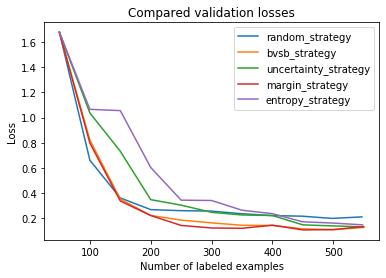

In [11]:
plt.title("Compared validation losses")
plt.xlabel("Number of labeled examples")
plt.ylabel("Loss")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,2], label=name)
plt.legend(loc='upper right')
plt.show()

Graphs above reveal that the best strategies consist in incrementally adding most uncertain samples to the training set, where the uncertainty function depends on the best and second best prediction. In particular, they clearly outperform strategies based on global measures over the per-class scores such as entropy, which confirms the intuitions and experiments detailed in [this paper](https://www.researchgate.net/publication/221363883_Multi-class_active_learning_for_image_classification).

Best-versus-Second-Best (BvSB) strategy and margin strategy are very similar and reach almost identical accuracy results, with a slight advantage for BvSB strategy.

The provided code only implement the "random" strategy, which chooses examples at random to label them. Your task is to compare it to other, more guided strategies. For example:

- a strategy that would label in priority the examples for which the classifier is the most uncertain, as measured by the entropy of its output
- a strategy that would label in priority the examples that appear to be near the frontier between the classes: examples for which the highest and second-highest prediction values of the classifier are close to each other.

You can also try to use other relevant decision criterion for choosing which examples to label, and implement them as new strategies. It is also possible to combine strategies together, in order to combine the strong points of each of them.

**Some advice:**

Keep in mind that your goal is to reach the best possible validation accuracy with as little labelled training examples as possible. As such, don't forget to try and change the number of initial examples for labelling, as well as the number of examples your strategy will request for labelling at each round.

Also keep in mind that you network will be trained on possibly very small datasets (think of only a few hundred of examples), while the validation set contains 5000 examples. Be careful of the risks of over-fitting, adjust your network structure and the training time (`num_iter`) appropriately.

As a baseline, you should be able to reach at least 90% of validation accuracy with less than 500 labelled examples.

**When you are done, you're asked to upload this notebook with your model, the different strategies your compared with the graphs generated by the previous code. Your strategies functions should be commented to explain what each strategy does, and which one is your best strategy.**